In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import tree
import joblib


from sklearn.metrics import accuracy_score

In [38]:
# Load the dataset
df = pd.read_csv(r'D:\lums\work stuff\notebooks\Week 2\Wine\WineQT.csv')

# print(df.describe())
# print(df.info())
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,3
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1592
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1593
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1594
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1595


In [39]:
# Check for missing values
#print(df.isnull().sum())

# Check duplicates
duplicates = df.duplicated()
# View how many duplicate rows exist
#print("Number of duplicate rows:", duplicates.sum())

# Drop Id column
df.drop(columns=['Id'], inplace=True)
df['qualitybin'] = (df['quality']>=7).astype(int)  # Convert quality to binary classification (0 or 1)
df = df.drop(columns=['quality'])  # Drop the original quality column


print(df['qualitybin'].value_counts())


qualitybin
0    984
1    159
Name: count, dtype: int64


In [40]:
# Replace whitespaces in all column names with underscores
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'qualitybin'],
      dtype='object')

### Correlations

In [41]:
# Correlations
df.corr()['qualitybin'].sort_values(ascending=False)

# Function to drop features with low correlation with target
def drop_low_corr_features(df, threshold=0.1):
    # Exclude the target
    correlations = df.corr()['qualitybin'].drop('qualitybin')
    
    # Find low-correlation features
    low_corr_features = correlations[abs(correlations) < threshold].index
    
    print("Dropped features: ", low_corr_features.tolist())
    
    # Drop them from the DataFrame
    df = df.drop(columns=low_corr_features)
    return df


# Drop low corr features
df = drop_low_corr_features(df)
print(df['qualitybin'].value_counts())



Dropped features:  ['residual_sugar', 'free_sulfur_dioxide', 'pH']
qualitybin
0    984
1    159
Name: count, dtype: int64


### MultiColinearity

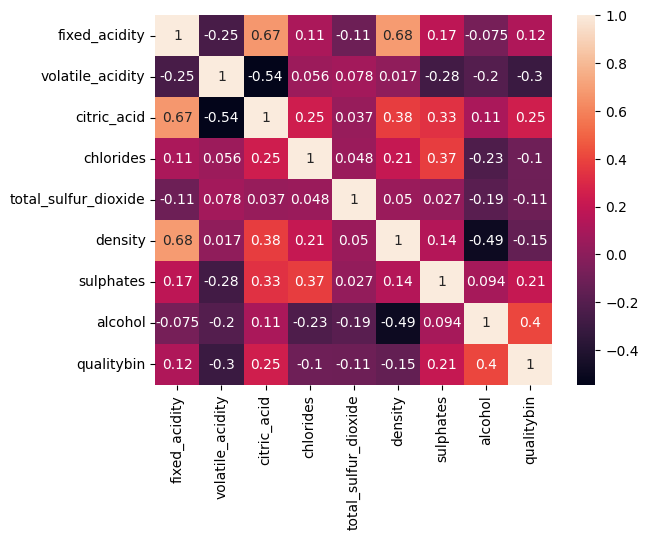

No high correlation pairs found (|correlation| > 0.8)
qualitybin
0    984
1    159
Name: count, dtype: int64


In [42]:
sns.heatmap(df.corr(), annot=True)
plt.show()

# Check multi-collinearity
def check_multicollinearity(df, threshold=0.8):
    corr_matrix = df.corr()
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                high_corr_pairs.append((colname, corr_matrix.columns[j]))
    return high_corr_pairs

# Check multi-collinearity
high_corr_pairs = check_multicollinearity(df)
if high_corr_pairs:
    print("High correlation pairs (|correlation| > 0.8):")
    for pair in high_corr_pairs:
        print(pair)
else:
    print("No high correlation pairs found (|correlation| > 0.8)")

print(df['qualitybin'].value_counts())


### Removing Outliers

In [ ]:
# Function to remove outliers from numeric feature columns only (not the target)
def remove_outliers(df, threshold=1.5):
    df_out = df.copy()
    
    # Exclude the target column from outlier detection
    numeric_cols = df_out.select_dtypes(include=[np.number]).columns.drop('qualitybin')
    
    outlier_indices = set()
    
    for column in numeric_cols:
        Q1 = df_out[column].quantile(0.25)
        Q3 = df_out[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers in this column
        outliers = df_out[(df_out[column] < lower_bound) | (df_out[column] > upper_bound)].index
        outlier_indices.update(outliers)
    
    # Drop rows that were outliers in any column
    df_cleaned = df_out.drop(index=outlier_indices)
    return df_cleaned

# Remove outliers and display class balance
print("Shape before removing outliers:", df.shape)
print("Class balance before:\n", df['qualitybin'].value_counts())

df = remove_outliers(df)

print("Shape after removing outliers:", df.shape)
print("Class balance after:\n", df['qualitybin'].value_counts())


Shape before removing outliers: (1143, 9)
Class balance before:
 qualitybin
0    984
1    159
Name: count, dtype: int64
Shape after removing outliers: (938, 9)
Class balance after:
 qualitybin
0    811
1    127
Name: count, dtype: int64


### Visualizing the Dataset

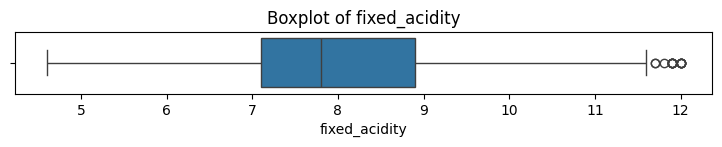

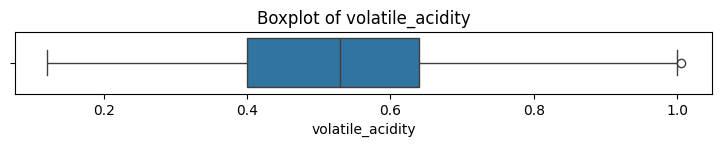

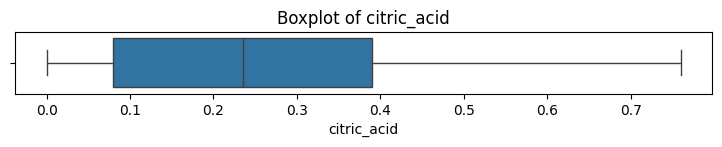

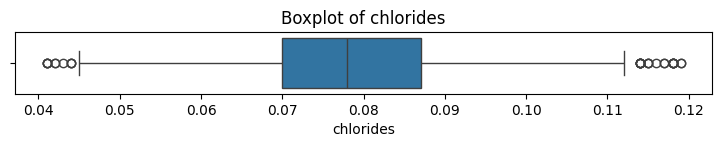

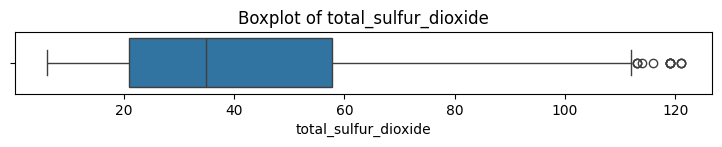

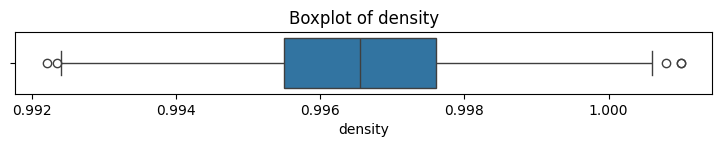

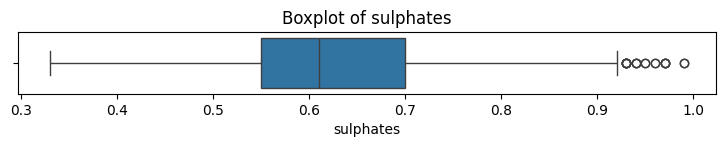

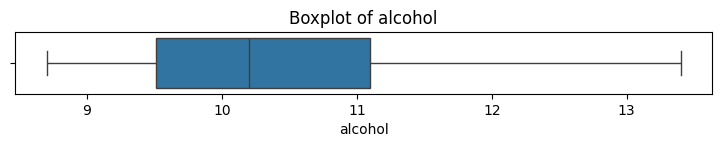

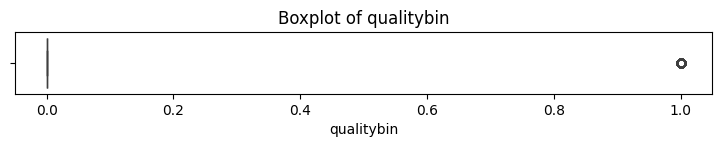

In [44]:
# Visualizing outliers
for column in df.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(9, 0.8))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

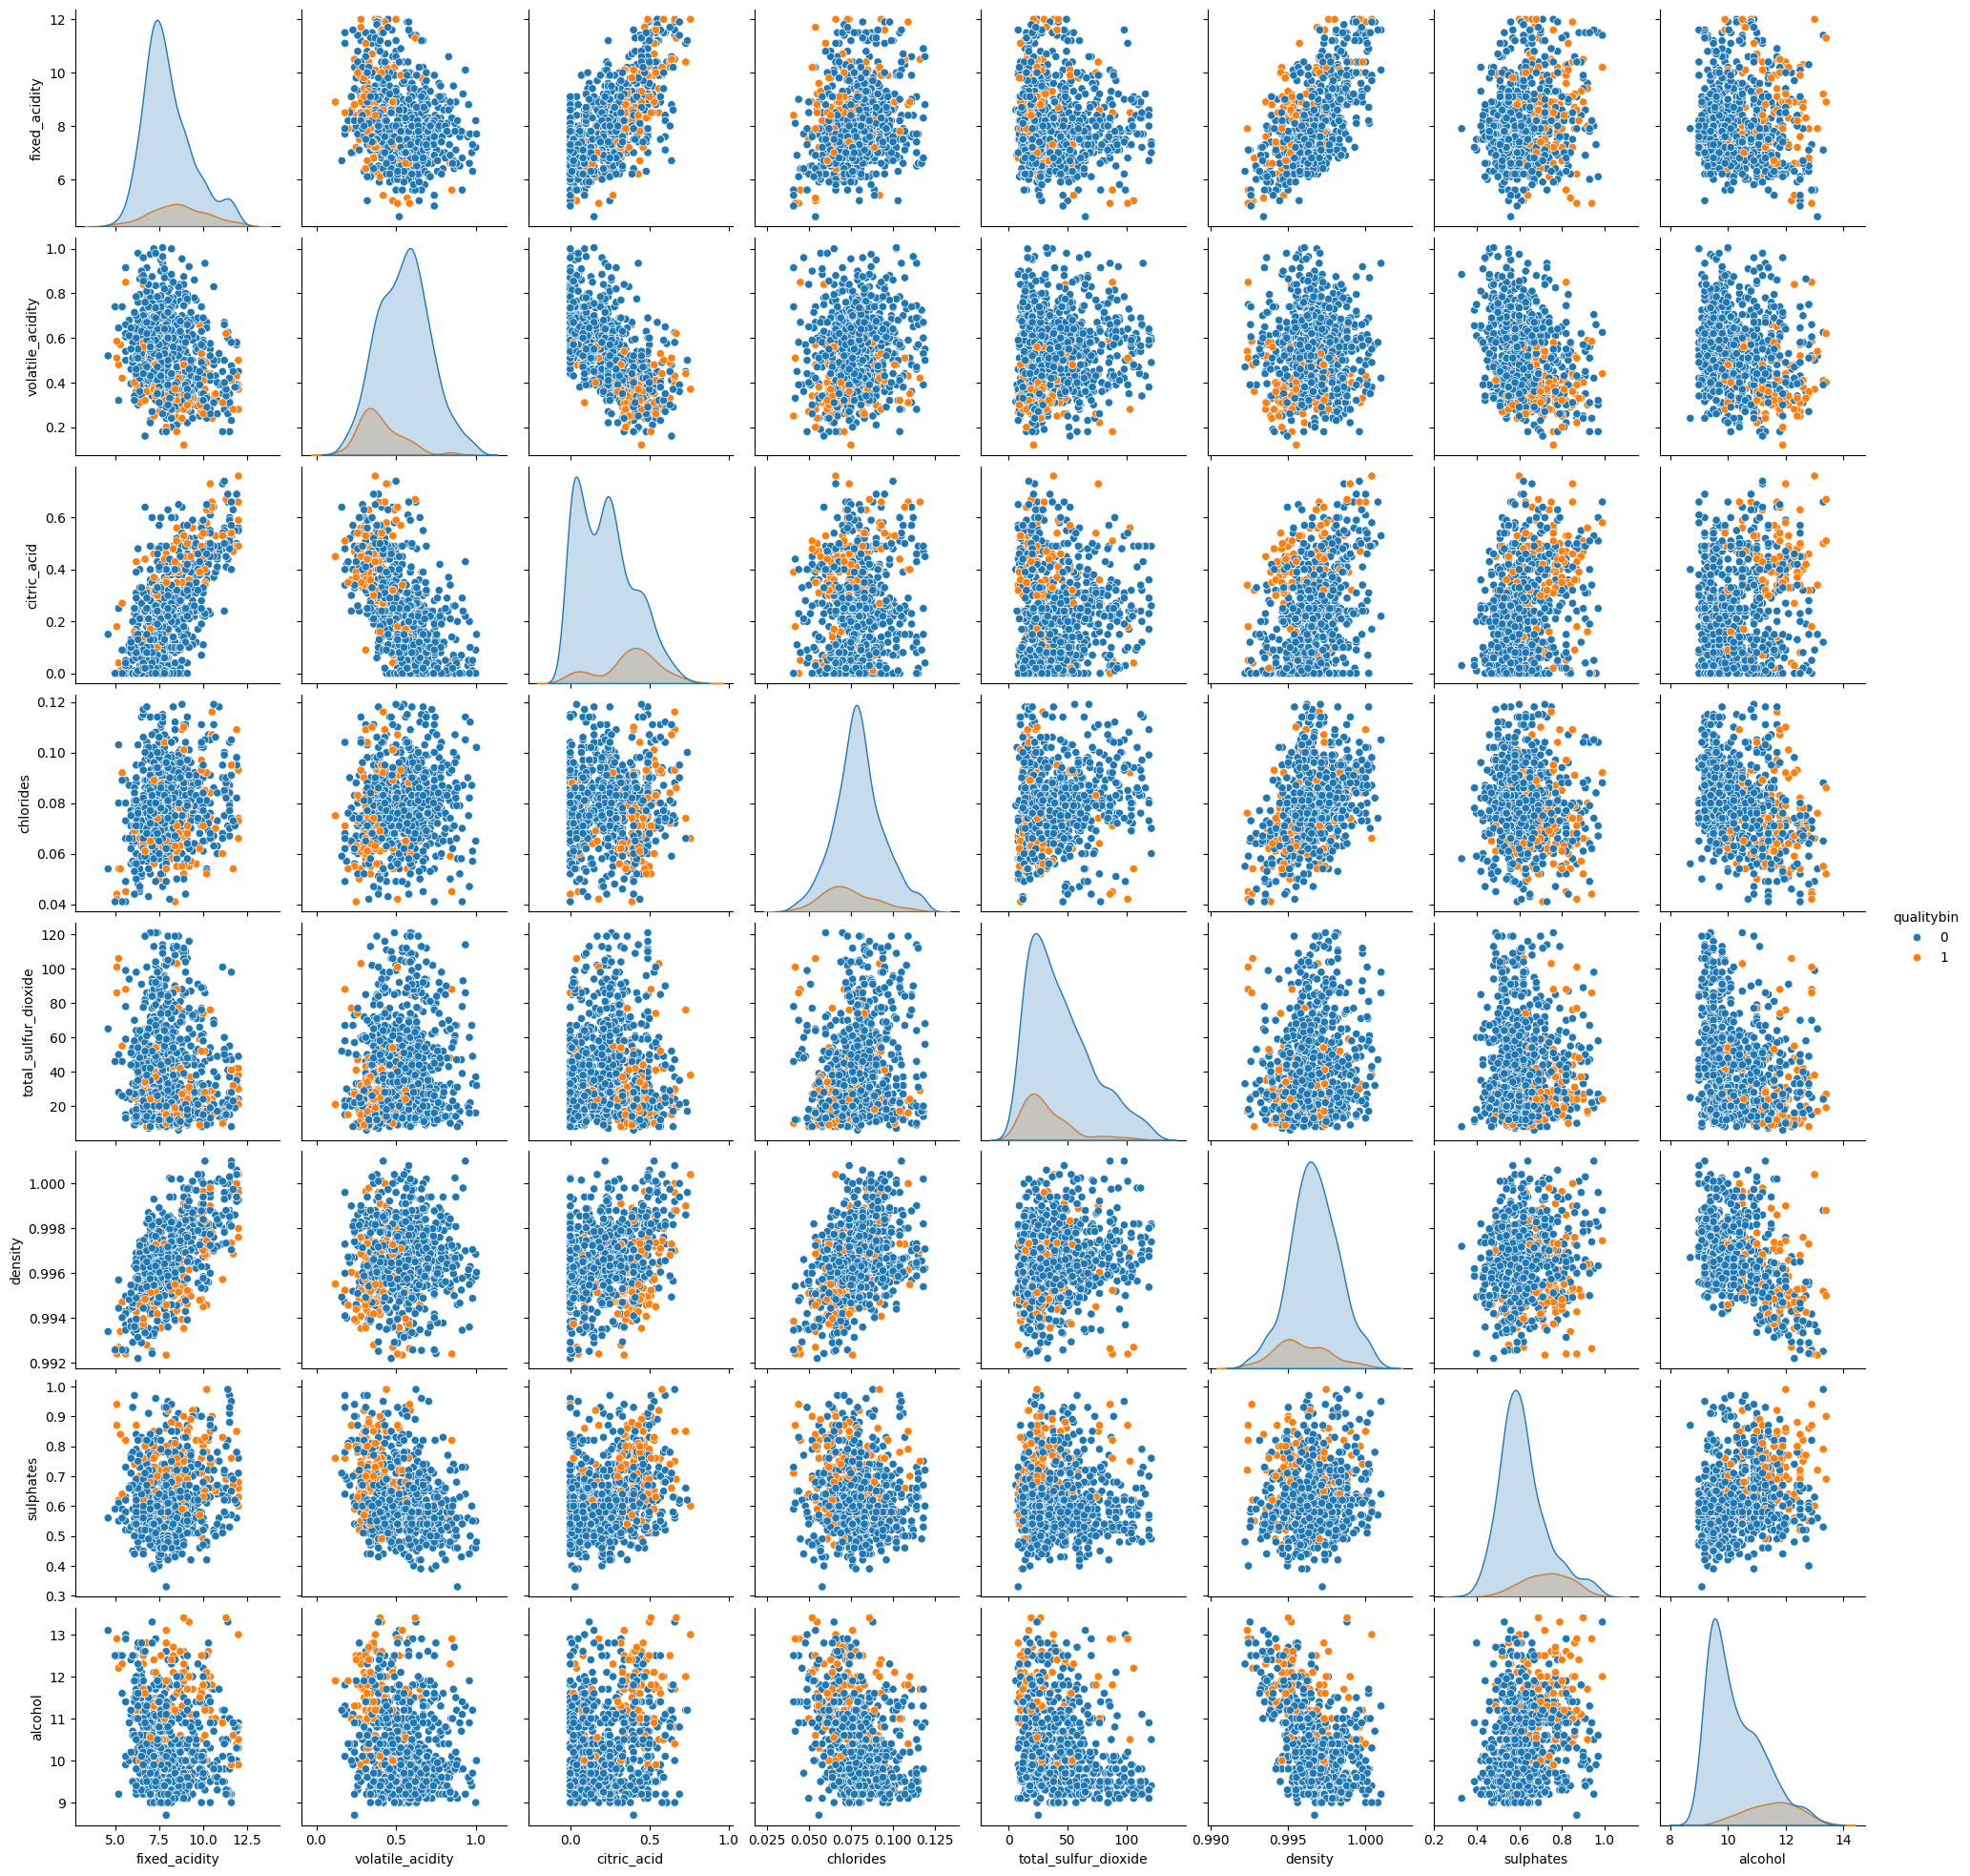

In [45]:
sns.pairplot(df, hue='qualitybin', diag_kind='kde')
plt.show()

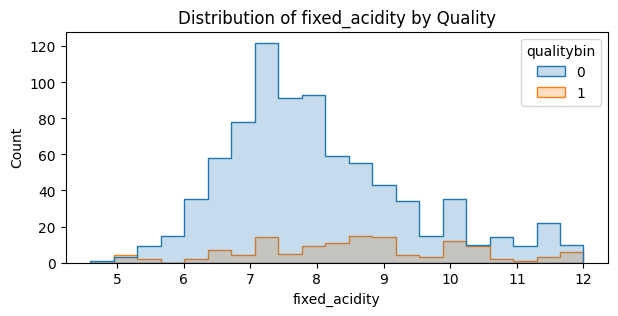

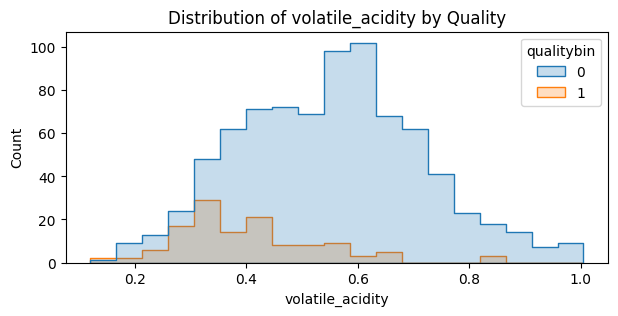

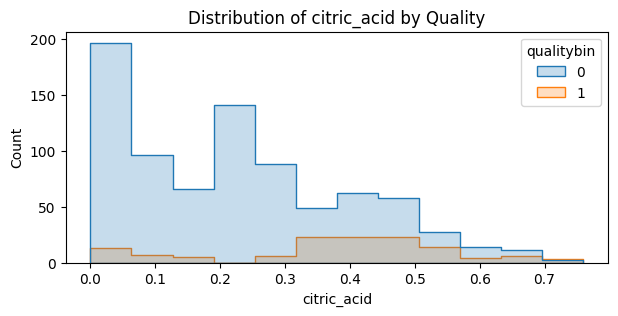

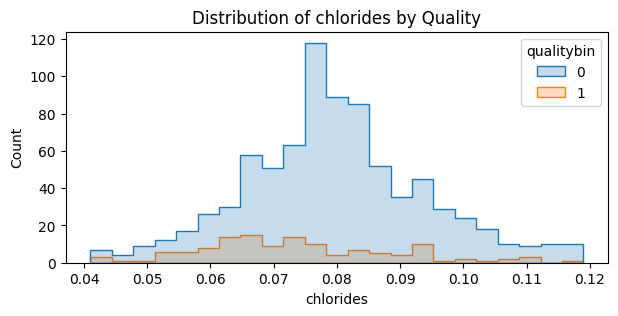

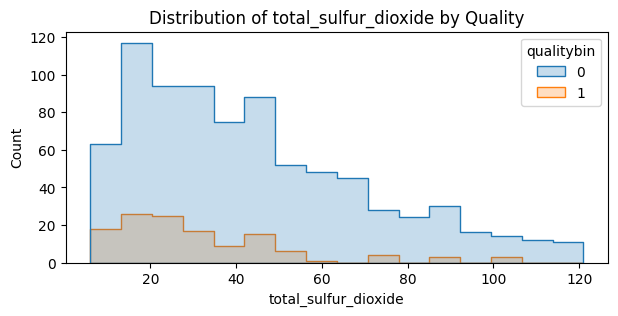

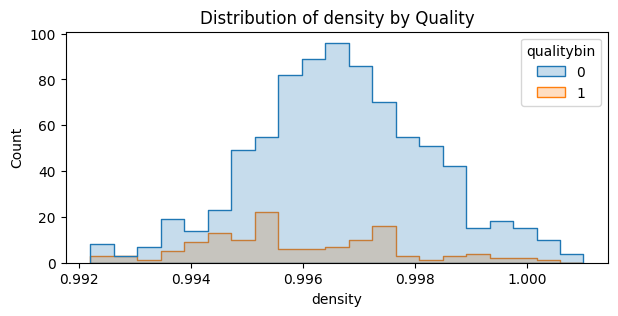

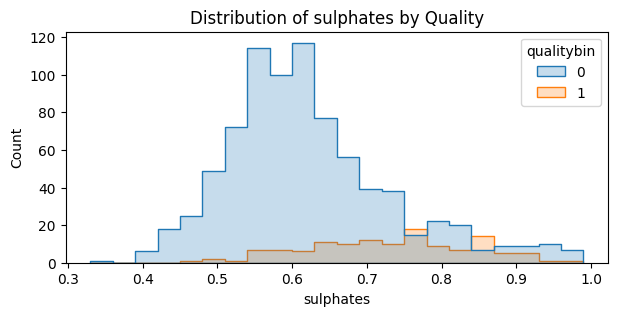

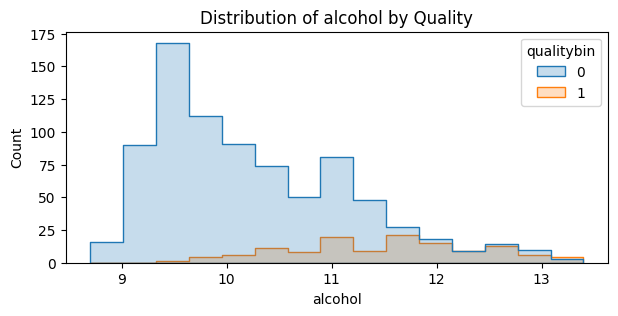

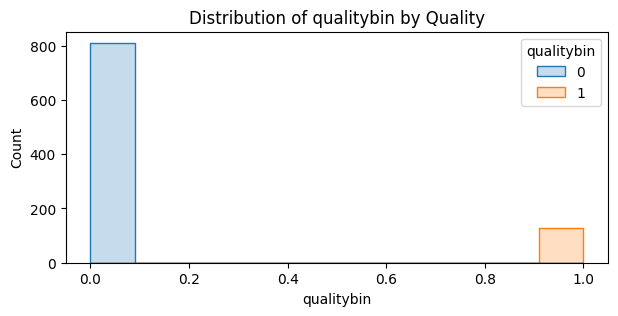

In [46]:
for column in df.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(7, 3))
    sns.histplot(data=df, x=column, hue='qualitybin', element='step')
    plt.title(f'Distribution of {column} by Quality')
    plt.show()

### Preprocessing

In [48]:
X = df.drop(columns=['qualitybin'])
print(X.columns)
y = df['qualitybin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Update numeric_features and preprocessor to use only selected features
numeric_features = X.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)


Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'chlorides',
       'total_sulfur_dioxide', 'density', 'sulphates', 'alcohol'],
      dtype='object')


In [49]:
model_params = {
    'Decision Tree' : {
        'model' : DecisionTreeClassifier(random_state=42),
        'params' : {
            'classifier__max_depth' : [3,5,7,None],
            'classifier__min_samples_split' : [2,5,10]
        }
    },
    'kNN' : {
        'model' : KNeighborsClassifier(),
        'params' : {
            'classifier__n_neighbors' : list(range(12, 17)),
            'classifier__weights' : ['uniform', 'distance'],
            'classifier__p' : [1, 2, 3]
        }
    },
    'Naive Bayes' : {
        'model' : GaussianNB(),
        'params' : {
            'classifier__var_smoothing' : [1e-9, 1e-10, 1e-11]
        }
    },
}

### Training the model using Gridsearch

In [50]:
# Run grid search for each model on full X_train/X_test (pipeline will select features)
for name, mp in model_params.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', mp['model'])
    ])
    grid = GridSearchCV(pipe, mp['params'], cv=5)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    # Save the best pipeline for this model
    joblib.dump(best_model, f"Wine_{name.replace(' ', '_').lower()}.joblib")

    print(f"🔍 {name} Results")
    print("Best CV Accuracy:", grid.best_score_)
    print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
    print("Best Params:", grid.best_params_)
    print("-" * 50)

🔍 Decision Tree Results
Best CV Accuracy: 0.884
Test Set Accuracy: 0.8936170212765957
Best Params: {'classifier__max_depth': 3, 'classifier__min_samples_split': 2}
--------------------------------------------------
🔍 kNN Results
Best CV Accuracy: 0.8973333333333333
Test Set Accuracy: 0.9202127659574468
Best Params: {'classifier__n_neighbors': 13, 'classifier__p': 1, 'classifier__weights': 'distance'}
--------------------------------------------------
🔍 Naive Bayes Results
Best CV Accuracy: 0.8600000000000001
Test Set Accuracy: 0.8670212765957447
Best Params: {'classifier__var_smoothing': 1e-09}
--------------------------------------------------


### Visualizing Model Performance

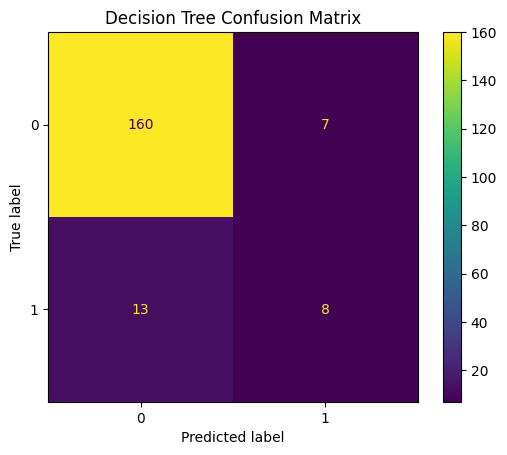

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       167
           1       0.53      0.38      0.44        21

    accuracy                           0.89       188
   macro avg       0.73      0.67      0.69       188
weighted avg       0.88      0.89      0.89       188

--------------------------------------------------


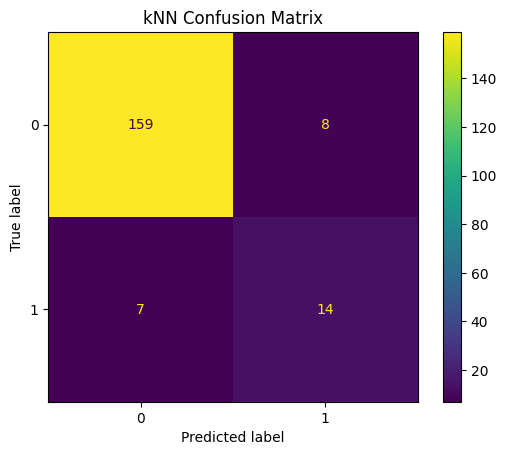

Classification Report for kNN:

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       167
           1       0.64      0.67      0.65        21

    accuracy                           0.92       188
   macro avg       0.80      0.81      0.80       188
weighted avg       0.92      0.92      0.92       188

--------------------------------------------------


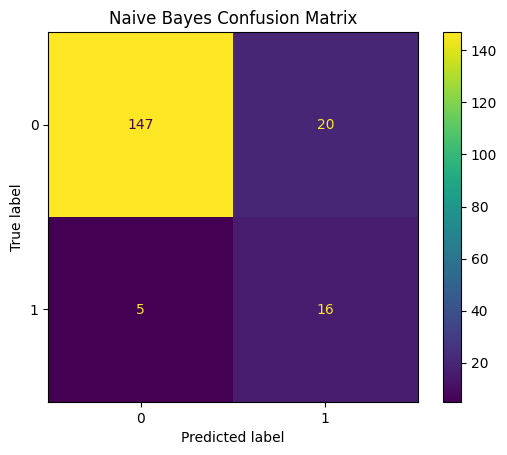

Classification Report for Naive Bayes:

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       167
           1       0.44      0.76      0.56        21

    accuracy                           0.87       188
   macro avg       0.71      0.82      0.74       188
weighted avg       0.91      0.87      0.88       188

--------------------------------------------------


In [51]:
from sklearn.metrics import (
    ConfusionMatrixDisplay, roc_curve, auc, 
    precision_recall_curve, classification_report, accuracy_score
)

import matplotlib.pyplot as plt

# Store results for comparison
results = {}
roc_curves = {}
pr_curves = {}
reports = {}

for name, mp in model_params.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', mp['model'])
    ])
    grid = GridSearchCV(pipe, mp['params'], cv=5)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_curves[name] = (fpr, tpr, auc(fpr, tpr))

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_curves[name] = (recall, precision)

    # Classification Report
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))
    print("-" * 50)



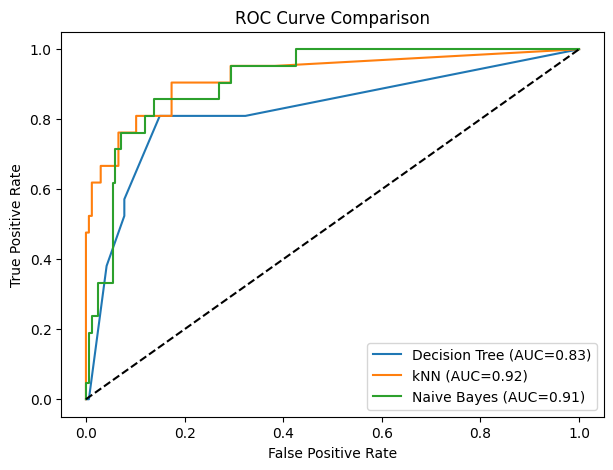

In [52]:
# Plot ROC Curves
plt.figure(figsize=(7,5))
for name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

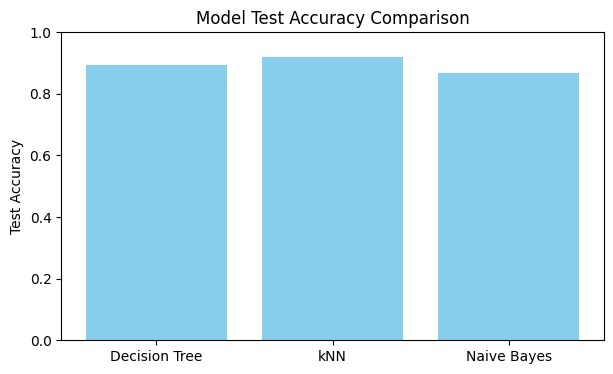

In [53]:
# Bar Plot of Test Accuracies
plt.figure(figsize=(7,4))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel("Test Accuracy")
plt.title("Model Test Accuracy Comparison")
plt.ylim(0, 1)
plt.show()